In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
import json
import configparser
from pathlib import Path
import os
import numpy as np

def RMSE(y_real, y_predict):
    return np.sqrt(MSE(y_real, y_predict))

configs = configparser.ConfigParser()
configs.read("../configuracoes.conf",encoding='utf-8')

data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
qtd_Meses = int(configs["DEFAULT"]["meses"])
regiao = configs["DEFAULT"]["regiao"]

In [2]:
df = pd.read_excel(path, parse_dates=['ano'])
df.preco = df.preco
train = df.iloc[-9-qtd_Meses::]
train = train.iloc[:-qtd_Meses:]
val = df.iloc[-qtd_Meses::]
val_grafico = df.iloc[-qtd_Meses - 1::]

models = ['RNN', 'LSTM', 'CNN']
resultados = {model:[] for model in models}

for model in models:
    with open(f'previsoes/previsao_{model}_cesta_basica_{regiao}_{qtd_Meses}_meses.json','r') as file:
        resultado = json.load(file)
        resultado['cesta_basica'] = resultado['cesta_basica'].replace("[", "")
        resultado['cesta_basica'] = resultado['cesta_basica'].replace("]", "")
        temp = resultado['cesta_basica'].split(',')
        for valor in temp:
            if model != "RNNRecursivo":
                resultados[model].append(float(valor) * 1000)
            else:
                resultados[model].append(float(valor))
            

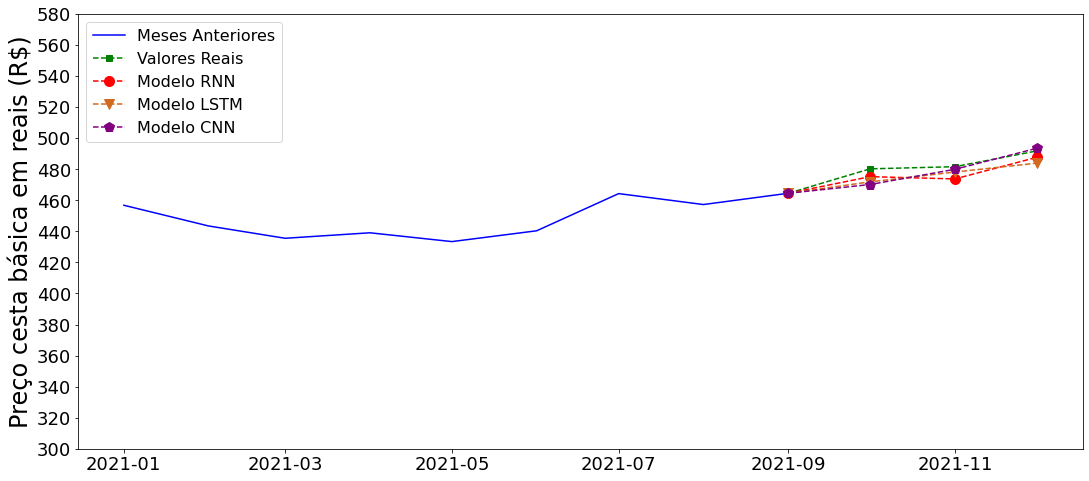

In [3]:
cores = ['red', 'chocolate', 'purple']
markers = ['o', 'v', 'p']

fig, ax = plt.subplots(1,1)
fig.set_figwidth(18)
fig.set_figheight(8)

ax.plot(train.ano.values, train.preco.values, label = 'Meses Anteriores', color = 'blue')
ax.plot(val_grafico.ano.values, val_grafico.preco.values, label = 'Valores Reais', color = 'green', ls ='--', marker='s')
ax.set_ylabel("Preço cesta básica em reais (R$)", size = 24)

for model, cor, marker in zip(models, cores, markers):
    ax.plot(val_grafico.ano.values, val_grafico.preco[:-qtd_Meses:].values.tolist() + resultados[model],
    label=f'Modelo {model}', color = cor, ls ='--', marker=marker, markersize=10)

plt.xticks(size=18)
plt.yticks([i for i in range(300,600, 20)], size=18)

#plt.title(f"Previsões dos últimos {qtd_Meses} meses de {regiao} em 2021", size=25)
plt.legend(loc='upper left', fontsize=16)
plt.savefig(fname=f'models_previsao_{qtd_Meses}_meses_{regiao}_.png')

In [4]:
metrics_index = ['MAE', 'MSE', 'RMSE', 'MAPE(%)']

resultados_metricas = {model:[] for model in models}

for model in models:
    for metric in [MAE, MSE, RMSE, MAPE]:
        if metric == MAPE:
            resultados_metricas[model].append(100 * round(metric(val.preco, resultados[model]), 5))
        else:
            resultados_metricas[model].append(round(metric(val.preco, resultados[model]), 5))

resultados_metricas = pd.DataFrame(resultados_metricas, index=metrics_index).T
resultados_metricas

,MAE,MSE,RMSE,MAPE(%)
RNN,5.67590,34.79684,5.89888,1.174
LSTM,6.55844,47.91181,6.92184,1.352
CNN,4.49677,35.88592,5.99049,0.933
